# CS 109A/Final Project: Data Processing and EDA  

# ADNI Alzheimer's dataset



### PART 2: AD Dream Challenge Subchallenge 3  


In the second part of the final project, we will focus on the question if we can predict the mental state of a patient from brain imaging data.  
One hallmark of Alzheimer's disease is the cognitive impairment caused by dementia in general and Alzheimer's disease in particular. Since the psychological pathology develops relatively late in the disease progression, it would be advantageous to be able to predict the mental state from MRI brain imaging data which is routinely acquired in clinical settings (e.g. to exclude other types of dementia). In our analysis, we follow closely the the guidelines given in the AD Big Data Dream Challenge Subchallenge 3.  
We downloaded the data for this challenge from ...
The data consists of 2150 measurements of brain geometry derived from 3D MRI images of 628 patients as well as some demographic data (education, gender, race) and some diagnostic data (MMSE score, Diagnosis, Apoe4 genotype). In this part of the project, we will try to predict the Mini Mental State Exam (MMSE) score only from imaging and demographic data.


In [1]:
# import required modules
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import pearsonr
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

import seaborn.apionly as sns
sns.set_context("poster")
from IPython.display import display
matplotlib.style.use('ggplot')
%matplotlib inline


# 1. Data Cleaning and EDA

  
  
We load the data and have a look at the imaging part and the demographic part.

In [2]:
#read data from file
data = pd.read_csv('baseline_data.csv')
print(data.shape)
# a lot more predictors than observations, lots of potential for overfitting

print(len(data.RID.unique()))
# no doubles in patient ID, so we can keep rows as patients/observations

#split data into image data and demographic data
image_data = data.iloc[:,:-13].copy()
demographic = data.iloc[:,-13:].copy()
mmse = data['MMSE']
# for diagnosis: CN = 0, LMCI = 1, AD = 2
dx = (data['DX.bl'] == 'LMCI') * 1. + (data['DX.bl'] == 'AD') * 2.

display(image_data.head())
display(demographic.head())

(628, 2163)
628


,area.1002,area.1003,area.1005,area.1006,area.1007,area.1008,area.1009,area.1011,area.1012,area.1013,...,Thickness..thickinthehead..2021,Thickness..thickinthehead..2022,Thickness..thickinthehead..2024,Thickness..thickinthehead..2025,Thickness..thickinthehead..2028,Thickness..thickinthehead..2029,Thickness..thickinthehead..2030,Thickness..thickinthehead..2031,Thickness..thickinthehead..2034,Thickness..thickinthehead..2035
0,612.577638,2514.366512,1652.050796,731.718725,3794.131041,5012.960558,4951.994756,5666.361234,2568.454160,3147.024829,...,0.2927,0.3276,0.3645,0.4358,0.4446,0.3887,0.4558,0.4107,0.3230,0.4806
1,735.292087,2435.629408,1947.966106,721.230657,4101.035394,4469.814924,4002.936490,5427.875646,2778.342103,3907.628206,...,0.3240,0.3247,0.3886,0.4416,0.4823,0.3790,0.4650,0.4499,0.3923,0.5315
2,1080.976588,2190.801306,1613.620315,636.078912,5146.969073,6192.609394,4640.889149,6854.023127,3282.902615,3677.408865,...,0.2343,0.2491,0.2727,0.3267,0.3098,0.3001,0.3069,0.3129,0.2369,0.3357
3,840.850798,2293.601605,1599.807666,729.344575,3351.924971,4231.417941,3991.795466,5047.106646,2599.222056,3339.590461,...,0.2643,0.2978,0.3116,0.3823,0.3976,0.3235,0.3808,0.3769,0.2902,0.4899
4,592.882184,1827.195664,1479.821407,535.558408,3459.934118,5063.103074,3583.954659,4120.492969,2462.352998,2737.467877,...,0.2603,0.3267,0.3871,0.4370,0.4861,0.3592,0.4216,0.4238,0.3356,0.4893


,directory.id,Subject,RID,Image.Data.ID,DX.bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype
0,178eeac87ff2460568a8709ba32f9b1e,002_S_0295,295,45108,CN,84.8,Male,18,Not Hisp/Latino,White,1,28,True
1,4d953ce78fb484052e8b735e5493770a,002_S_0413,413,45117,CN,76.3,Female,16,Not Hisp/Latino,White,0,29,True
2,da022a5df80d136d3aa26bfa06702278,002_S_0619,619,48617,AD,77.5,Male,12,Not Hisp/Latino,White,2,22,False
3,7d700a43e372c9dfabd6c2dfdc0edcf8,002_S_0685,685,40683,CN,89.6,Female,16,Not Hisp/Latino,White,0,30,True
4,c033f6026da1179ab7b5f7e4f5559f59,002_S_0729,729,40708,LMCI,65.1,Female,16,Not Hisp/Latino,White,1,27,True


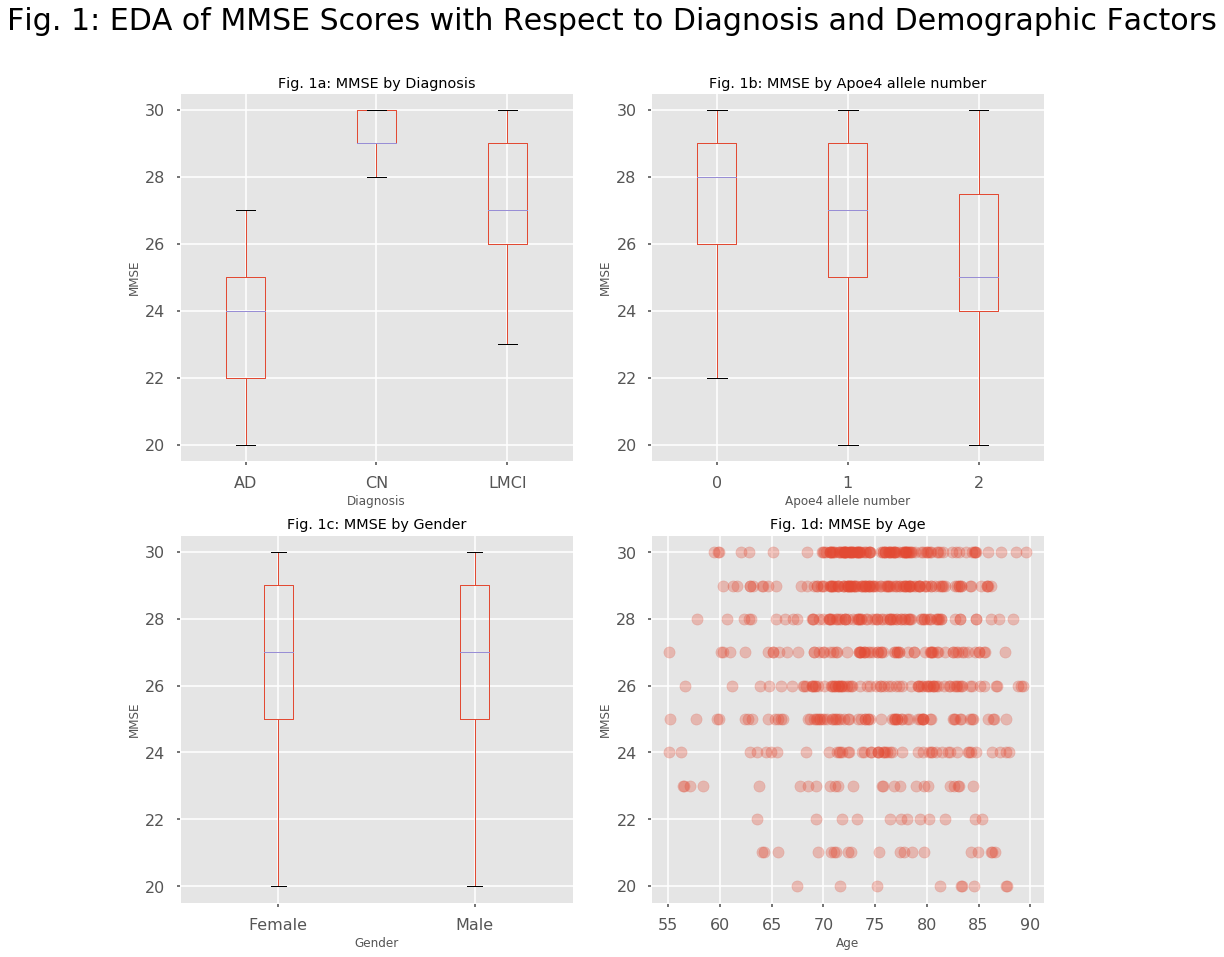

In [3]:
fig1 = plt.figure(figsize = [15,15])


plt.subplot(2,2,1)
ax = plt.gca()
data.boxplot('MMSE',by = ['DX.bl'], ax = ax)
plt.title('Fig. 1a: MMSE by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('MMSE')

plt.subplot(2,2,2)
ax = plt.gca()
data.boxplot('MMSE',by = ['APOE4'], ax = ax)
plt.title('Fig. 1b: MMSE by Apoe4 allele number')
plt.xlabel('Apoe4 allele number')
plt.ylabel('MMSE')

plt.subplot(2,2,3)
ax = plt.gca()
data.boxplot('MMSE',by = ['PTGENDER'], ax = ax)
plt.title('Fig. 1c: MMSE by Gender')
plt.xlabel('Gender')
plt.ylabel('MMSE')

plt.subplot(2,2,4)
ax = plt.gca()
plt.scatter(data['AGE'],mmse,alpha=0.3)
plt.title('Fig. 1d: MMSE by Age')
plt.xlabel('Age')
plt.ylabel('MMSE');

fig1.suptitle('Fig. 1: EDA of MMSE Scores with Respect to Diagnosis and Demographic Factors',fontsize= 30);

There is a clear correlation of MMSE score with the diagnosis of the patient. Healthy control patients (CN) have an MMSE score near the maximum of 30, whereas patients with light cognitive impairment (LMCI) have a lower median MMSE and Alzheimer's disease patients (AD) have the lowest median MMSE score.  This indicates that MMSE can be used to predict Alzheimer's disease or dementia in general.  
The MMSE score is also strongly correlated with the Apoe4 genotype. In particular, individuals that are homozygous for the Apoe4 allele, i.e. they have 2 copies of it, display a lower MMSE score.  
On the other hand, other demographic predictors like gender or age do not appear to be strongly correlated with the MMSE score.  
  
   
We now try to find the features in the imaging data that are most correlated with the MMSE score:

In [4]:
# find the image data columns that are most correlated with mmse

corr_coefs = []
pvals = []

for column in image_data.columns.values:
    coef,pval = pearsonr(image_data[column],mmse)
    corr_coefs.append(coef)
    pvals.append(pval)
    
print("image measurements most closely correlated with mmse score:")
best6 = image_data.columns.values[np.argsort(pvals)[:6]]
print(best6)


image measurements most closely correlated with mmse score:
['FreeSurfer.thickness..mean.1006' 'FreeSurfer.thickness..mean.2006'
 'FreeSurfer.thickness..25..1006' 'FreeSurfer.thickness..median.1006'
 'FreeSurfer.thickness..75..1006' 'FreeSurfer.thickness..25..1009']


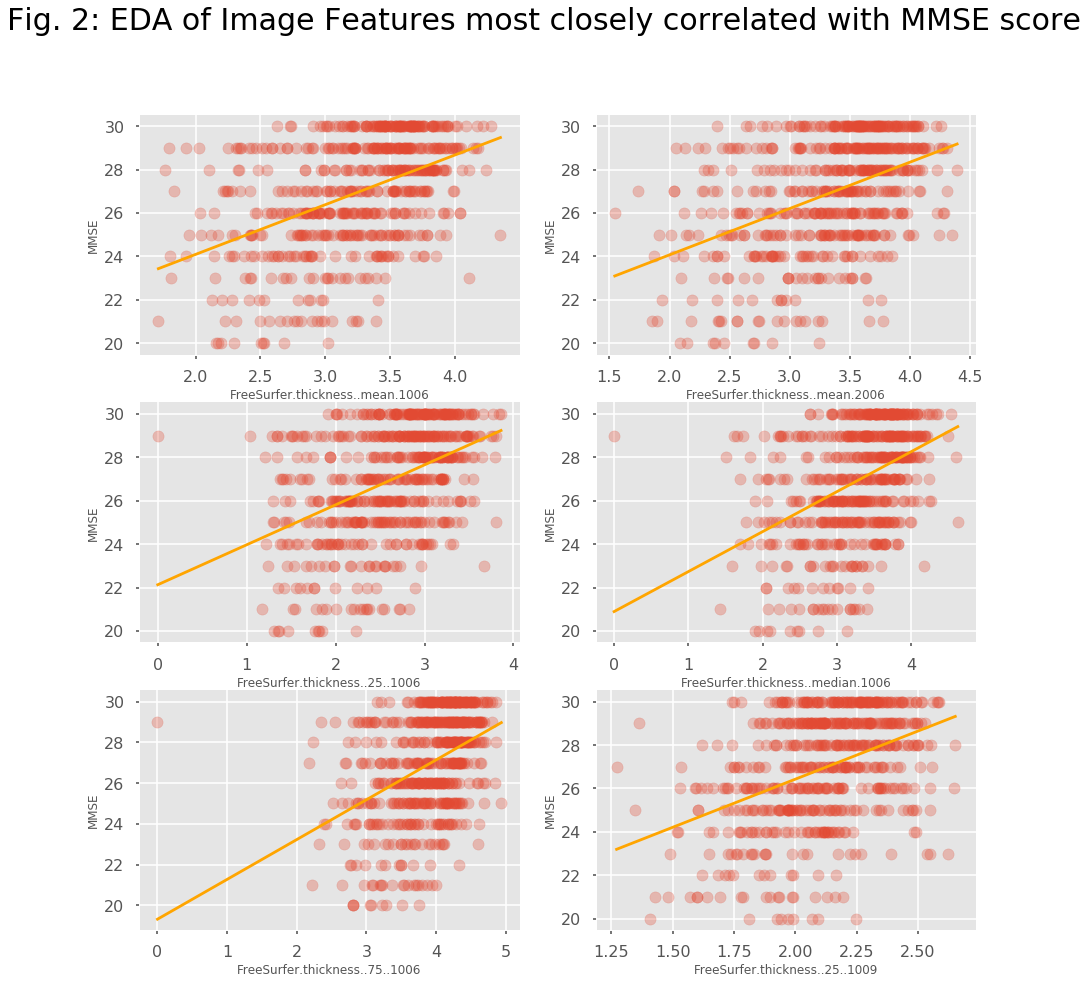

In [5]:
# plot mmse vs most closely correlated image measurements
fig2 = plt.figure(figsize= [15,15])

for i,feature in enumerate(best6):
    plt.subplot(3,2,i+1)
    plt.scatter(image_data[feature],mmse,alpha=0.3)
    plt.xlabel(feature)
    plt.ylabel('MMSE')
    beta1,beta0 = np.polyfit(image_data[feature],mmse,deg=1)
    f = lambda x: beta1 * x + beta0
    x = np.array([np.min(image_data[feature]), np.max(image_data[feature])])
    plt.plot(x,f(x),c='orange')
    sns.despine()
fig2.suptitle('Fig. 2: EDA of Image Features most closely correlated with MMSE score',fontsize= 30);  

Some of the features in the imaging data appear to be strongly correlated with the MMSE score which makes the analysis/prediction promising. 
We also notice that we now have 2159 predictors which is a lot more than the 628 observations we have in our complete dataset. This causes a big danger of overfitting any training data.  
We next clean up the demographic variables and split our data in training and test sets. Then we will check if we  have multi-colinearity in the imaging predictors.

In [6]:
# clean up demographic variables

# impute Unknown as Not Hisp/Latino and turn into binary with Hisp/Latino as 1.0, Non-Hisp/Latino as 0.0
demographic['PTETHCAT'] = (demographic.PTETHCAT == 'Hisp/Latino') * 1.

# race and number of Apoe4 alleles are turned into dummy variables
demographic = pd.get_dummies(demographic,columns=['PTRACCAT','APOE4'],drop_first=True)

# turn gender into a binary variable with Female = 1.0
demographic['PTGENDER'] = (demographic.PTGENDER == 'Female') * 1.

# change imputed_genotype from boolean to 0.0/1.0
demographic['imputed_genotype'] = (demographic.imputed_genotype == True)* 1.

# get X and y
y = mmse
y_dx = dx

image_columns = image_data.columns.values

# we discard the ID columns and the diagnosis column which would give away too much
demographic_columns = ['AGE','PTGENDER','PTEDUCAT','PTETHCAT','imputed_genotype','PTRACCAT_Black','PTRACCAT_White','APOE4_1','APOE4_2']


# and concatenate the image and remaining demographic data
X = pd.concat([image_data,demographic[demographic_columns]],axis=1)
print(X.shape)

#check that there is no NaN's in the data
print(np.sum(np.sum(X.isnull())))
# no NaN's

# train test split
X_train, X_test, y_train, y_test, y_dx_train, y_dx_test = train_test_split(X,y,y_dx,train_size = 0.75,random_state=8)


# standardize training and test
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

(628, 2159)
0


# 2. Checking Multi-Colinearity in the Imaging Data
  
  
    
      
We calculate a correlation matrix and display it as a heatmap

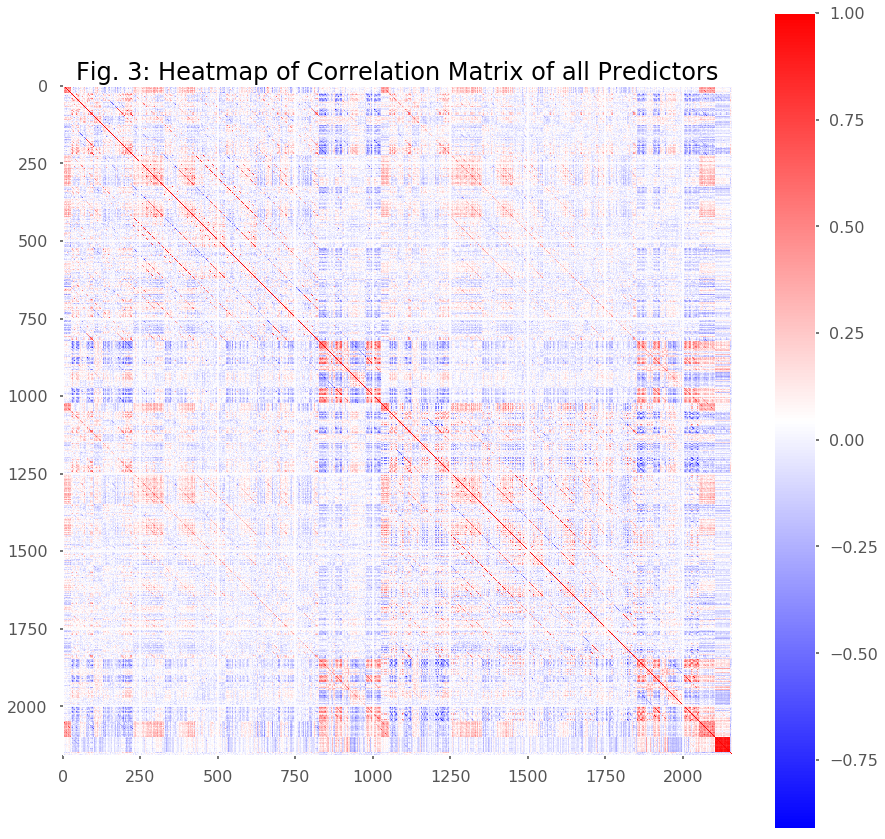

In [7]:
# get and plot correlation matrix
corr_mat = np.corrcoef(X_train.as_matrix().T)

# plot correlation matrix
fig3 = plt.figure(figsize = [15,15])
ax = plt.gca()
plt.set_cmap("bwr")
heatmap = plt.imshow(corr_mat)
plt.title('Fig. 3: Heatmap of Correlation Matrix of all Predictors',fontsize=24);
plt.colorbar(heatmap);

There is a lot of colinearity between the predictors in the imaging data. Colinear variables appear to be organized in ordered blocks. In order to get a working prediction model, we will have to reduce the dimensionality and co-linearity  first to reduce the danger of overfitting.

# 2. Simple Linear Regression Models

We first try a simple linear regression model with only the 2 best image features and one with all features.

In [8]:

# try a super-simple linear regression model only on the 2 best predictors

single_est = LinearRegression(fit_intercept = True)
best2 = best6[:1]
single_est.fit(X_train[best2],y_train)
y_hat_train = single_est.predict(X_train[best2])
y_hat_test = single_est.predict(X_test[best2])
print('simple linear regression model with only the 2 best predictors: ')
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))

# try a super-simple linear regression model on all predictors

simple_est = LinearRegression(fit_intercept = True)
simple_est.fit(X_train,y_train)
y_hat_train = simple_est.predict(X_train)
y_hat_test = simple_est.predict(X_test)
print('\nsimple linear regression model with all predictors: ')
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))


simple linear regression model with only the 2 best predictors: 
R2 score on training set:  0.196140812348
R2 score on test set:  0.247100650815

simple linear regression model with all predictors: 
R2 score on training set:  1.0
R2 score on test set:  -0.575703582103


Not surprisingly, the model with just 2 predictors suffers from high bias. On the other hand, given the large number of predictors and the multi-colinearity of the predictors, the model with all predictors suffers from high variance. We will use principal components analysis to reduce the dimensionality and eliminate colinearity.

# 3. Principal Component Analysis and Regularized Linear Regression
  
    
    
First, we reduce the dimensionality by principal component analysis and keep enough principal components that capture 90% of the variance in the data. 

In [9]:
# PCA transformation with PCs that account for 90% of variance in training set
fullpca = PCA(n_components = 0.9,svd_solver = 'full')
X_train_pca = fullpca.fit_transform(X_train)
X_test_pca = fullpca.transform(X_test)
total_pcs = X_train_pca.shape[1]
print(total_pcs)

197


We still have 198 predictors left after principal component analysis. Let's try a simple linear regression model

In [10]:
pca_lin_est = LinearRegression(fit_intercept = True)
pca_lin_est.fit(X_train_pca,y_train)
y_hat_train = pca_lin_est.predict(X_train_pca)
y_hat_test = pca_lin_est.predict(X_test_pca)
print('simple linear regression model on 198 PCA predictors: ')
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))


simple linear regression model on 198 PCA predictors: 
R2 score on training set:  0.607144507434
R2 score on test set:  0.146129866785


In [11]:
# try LASSO regularization
alphas = [100000,50000,10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01]
lasso_est = LassoCV(alphas=alphas,fit_intercept = True,cv=5,random_state=123)
lasso_est.fit(X_train_pca,y_train)
y_hat_train = lasso_est.predict(X_train_pca)
y_hat_test = lasso_est.predict(X_test_pca)

print('linear regression model with LASSO regularization on 198 PCA predictors: ')
print('Regularization parameter: ', lasso_est.alpha_)
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))


linear regression model with LASSO regularization on 198 PCA predictors: 
Regularization parameter:  0.5
R2 score on training set:  0.342337531313
R2 score on test set:  0.241402675028


In [12]:
# try ridge regularization

pca_est = RidgeCV(alphas=alphas,fit_intercept = True,cv=5)
pca_est.fit(X_train_pca,y_train)
print("Regularization parameter for Ridge regularization: ",pca_est.alpha_)
y_hat_train = pca_est.predict(X_train_pca)
y_hat_test = pca_est.predict(X_test_pca)
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))


Regularization parameter for Ridge regularization:  5000
R2 score on training set:  0.471061556011
R2 score on test set:  0.265014380849


In [13]:
# elastic net regularization
ratios = [.001,.01,.1, .5, .7, .9, .95, .99, 1]
elnet_est = ElasticNetCV(l1_ratio = ratios, alphas=alphas,fit_intercept = True,cv=5)
elnet_est.fit(X_train_pca,y_train)
y_hat_train = elnet_est.predict(X_train_pca)
y_hat_test = elnet_est.predict(X_test_pca)

print('linear regression model with Elastic Net regularization on 198 PCA predictors: ')
print('Regularization parameter: ', elnet_est.alpha_)
print('L1 ratio: ', elnet_est.l1_ratio_)
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))


linear regression model with Elastic Net regularization on 198 PCA predictors: 
Regularization parameter:  10.0
L1 ratio:  0.01
R2 score on training set:  0.430632422622
R2 score on test set:  0.267113344982


In [14]:
gbr_est = GradientBoostingRegressor(max_depth = 2, n_estimators = 50)
gbr_est.fit(X_train_pca,y_train)
y_hat_train = gbr_est.predict(X_train_pca)
y_hat_test = gbr_est.predict(X_test_pca)

print('gradient boosting model on 198 PCA predictors: ')
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))


gradient boosting model on 198 PCA predictors: 
R2 score on training set:  0.575804095843
R2 score on test set:  0.120705550968


In [15]:
# determine 5fold crossvalidation accuracy score on elastic net regression models depending on number of PCs included
scorelist = []
l1_ratios = []
alphas = []

#pcs = range(1,total_pcs+1)
pcs = [5,10,15,20,25,30,40,50,60,70,80,90,100,110,120,130,140,150,170,190,198]
for use_pcs in pcs:
    scores = cross_val_score(elnet_est,X_train_pca[:,:use_pcs],y_train,cv=5)
    
    scorelist.append(scores)
    l1_ratios.append(elnet_est.l1_ratio_)
    alphas.append(elnet_est.alpha_)
    




Optimal number of principal components:  50
linear regression model with Elastic Net regularization on 50 PCA predictors: 
Regularization parameter:  10.0
L1 ratio:  0.001
R2 score on training set:  0.372828154867
R2 score on test set:  0.260440049331
Pearsons Correlation Coefficient between prediction and ground truth:  0.514305148062


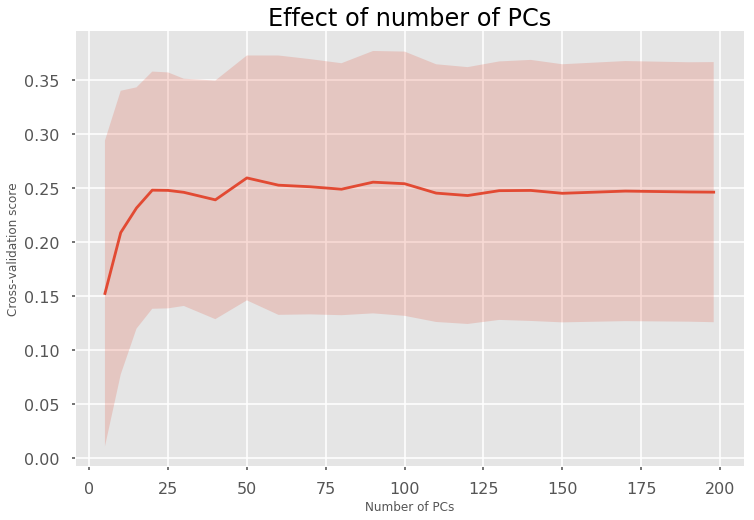

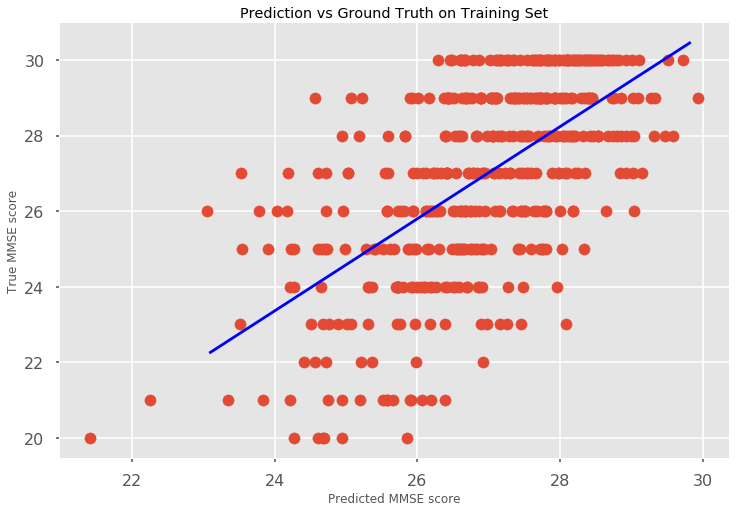

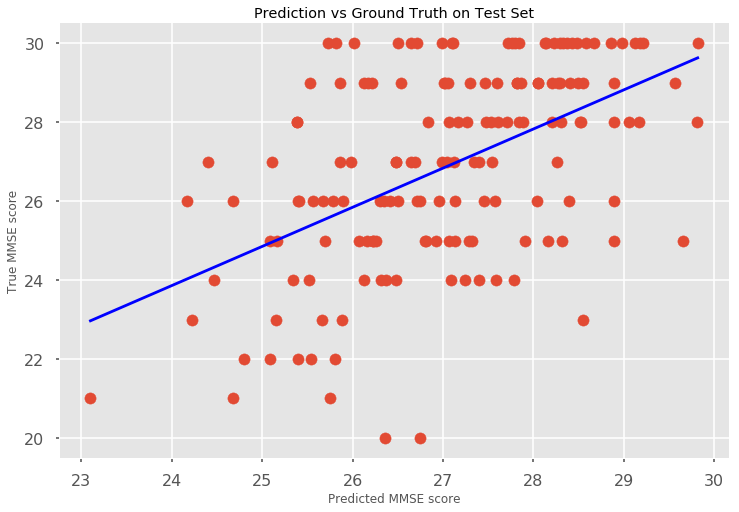

In [18]:
#plot crossvalidation score means and std as a function of number of PCs
score_array = np.vstack(scorelist)    
valid_means = score_array.mean(axis=1)
valid_stds = score_array.std(axis=1)

fig4 = plt.figure(figsize = [12,8])
plt.title('Effect of number of PCs', fontsize = 24)
ax = plt.gca()
plt.plot(pcs,valid_means)
ax.fill_between(pcs,valid_means+valid_stds,valid_means-valid_stds,alpha = 0.2)
ax.set_ylabel('Cross-validation score')
ax.set_xlabel('Number of PCs')
sns.despine()

# determine optimal number of PCs based on crossvalidation score and fit an elasticnet regression model
optimal_pcs = pcs[np.argmax(valid_means)]
print("\nOptimal number of principal components: ",optimal_pcs)

# re-evaluate L1 ratio and regularization parameters
elnet_est = ElasticNetCV(l1_ratio = ratios, alphas=alphas,fit_intercept = True,cv=5)
elnet_est.fit(X_train_pca[:,:optimal_pcs],y_train)
best_l1_ratio = elnet_est.l1_ratio_
best_alpha = elnet_est.alpha_

# fit to complete training set with ideal parameters
elnet_est = ElasticNet(alpha=best_alpha,l1_ratio=best_l1_ratio)
elnet_est.fit(X_train_pca[:,:optimal_pcs],y_train)

y_hat_train = elnet_est.predict(X_train_pca[:,:optimal_pcs])
y_hat_test = elnet_est.predict(X_test_pca[:,:optimal_pcs])

print('linear regression model with Elastic Net regularization on {} PCA predictors: '.format(optimal_pcs))
print('Regularization parameter: ', best_alpha)
print('L1 ratio: ', best_l1_ratio)
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))

corrcoef, _ = pearsonr(y_hat_test,y_test)
print('Pearsons Correlation Coefficient between prediction and ground truth: ',corrcoef)

fig5 = plt.figure(figsize = [12,8])
plt.scatter(y_hat_train,y_train)
beta1,beta0 = np.polyfit(y_hat_train,y_train,deg=1)
f = lambda x: beta1 * x + beta0
x = np.array([np.min(y_hat_test), np.max(y_hat_test)])
plt.plot(x,f(x),c='blue')
plt.xlabel('Predicted MMSE score')
plt.ylabel('True MMSE score')

plt.title('Prediction vs Ground Truth on Training Set')
sns.despine()

fig6 = plt.figure(figsize = [12,8])
plt.scatter(y_hat_test,y_test)
beta1,beta0 = np.polyfit(y_hat_test,y_test,deg=1)
f = lambda x: beta1 * x + beta0
x = np.array([np.min(y_hat_test), np.max(y_hat_test)])
plt.plot(x,f(x),c='blue')
plt.xlabel('Predicted MMSE score')
plt.ylabel('True MMSE score')

plt.title('Prediction vs Ground Truth on Test Set')
sns.despine()

In [26]:
# functions for correlation-based feature selection downloaded from https://github.com/jundongl/scikit-feature
from math import log
def elog(x):
    # for entropy, 0 log 0 = 0. but we get an error for putting log 0
    if x <= 0. or x >= 1.:
        return 0
    else:
        return x*log(x)

def entropyfromprobs(probs, base=2):
    # Turn a normalized list of probabilities of discrete outcomes into entropy (base 2)
    return -sum(map(elog, probs))/log(base)

def entropyd(sx, base=2):
    """
    Discrete entropy estimator given a list of samples which can be any hashable object
    """

    return entropyfromprobs(hist(sx), base=base)

def information_gain(f1, f2):
    """
    This function calculates the information gain, where ig(f1,f2) = H(f1) - H(f1|f2)
    Input
    -----
    f1: {numpy array}, shape (n_samples,)
    f2: {numpy array}, shape (n_samples,)
    Output
    ------
    ig: {float}
    """

    ig = entropyd(f1) - conditional_entropy(f1, f2)
    return ig

def midd(x, y):
    """
    Discrete mutual information estimator given a list of samples which can be any hashable object
    """

    return -entropyd(list(zip(x, y)))+entropyd(x)+entropyd(y)

def hist(sx):
    # Histogram from list of samples
    d = dict()
    for s in sx:
        d[s] = d.get(s, 0) + 1
    return map(lambda z: float(z)/len(sx), d.values())


def conditional_entropy(f1, f2):
    """
    This function calculates the conditional entropy, where ce = H(f1) - I(f1;f2)
    Input
    -----
    f1: {numpy array}, shape (n_samples,)
    f2: {numpy array}, shape (n_samples,)
    Output
    ------
    ce: {float}
        ce is conditional entropy of f1 and f2
    """

    ce = entropyd(f1) - midd(f1, f2)
    return ce


def su_calculation(f1, f2):
    """
    This function calculates the symmetrical uncertainty, where su(f1,f2) = 2*IG(f1,f2)/(H(f1)+H(f2))
    Input
    -----
    f1: {numpy array}, shape (n_samples,)
    f2: {numpy array}, shape (n_samples,)
    Output
    ------
    su: {float}
        su is the symmetrical uncertainty of f1 and f2
    """

    # calculate information gain of f1 and f2, t1 = ig(f1,f2)
    t1 = information_gain(f1, f2)
    # calculate entropy of f1, t2 = H(f1)
    t2 = entropyd(f1)
    # calculate entropy of f2, t3 = H(f2)
    t3 = entropyd(f2)
    # su(f1,f2) = 2*t1/(t2+t3)
    su = 2.0*t1/(t2+t3)

    return su

def merit_calculation(X, y):
    """
    This function calculates the merit of X given class labels y, where
    merits = (k * rcf)/sqrt(k+k*(k-1)*rff)
    rcf = (1/k)*sum(su(fi,y)) for all fi in X
    rff = (1/(k*(k-1)))*sum(su(fi,fj)) for all fi and fj in X
    Input
    ----------
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ----------
    merits: {float}
        merit of a feature subset X
    """

    n_samples, n_features = X.shape
    rff = 0
    rcf = 0
    for i in range(n_features):
        fi = X[:, i]
        rcf += su_calculation(fi, y)
        for j in range(n_features):
            if j > i:
                fj = X[:, j]
                rff += su_calculation(fi, fj)
    rff *= 2
    merits = rcf / np.sqrt(n_features + rff)
    return merits


def cfs(X, y):
    """
    This function uses a correlation based heuristic to evaluate the worth of features which is called CFS
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    F: {numpy array}
        index of selected features
    Reference
    ---------
    Zhao, Zheng et al. "Advancing Feature Selection Research - ASU Feature Selection Repository" 2010.
    """

    n_samples, n_features = X.shape
    F = []
    # M stores the merit values
    M = []
    while True:
        merit = -100000000000
        idx = -1
        for i in range(n_features):
            if i not in F:
                F.append(i)
                # calculate the merit of current selected features
                t = merit_calculation(X[:, F], y)
                if t > merit:
                    merit = t
                    idx = i
                F.pop()
        F.append(idx)
        M.append(merit)
        if len(M) > 5:
            if M[len(M)-1] <= M[len(M)-2]:
                if M[len(M)-2] <= M[len(M)-3]:
                    if M[len(M)-3] <= M[len(M)-4]:
                        if M[len(M)-4] <= M[len(M)-5]:
                            break
    return np.array(F)
#best_predictors = cfs(X_train.as_matrix(),y_train)


[249  48 180 191 198 206]


In [35]:
best_predictors = [249,48,180,191,198,206]
best_predictors = list(X_train.columns.values[best_predictors])
print(best_predictors)
X_train_feat = X_train[best_predictors]
X_test_feat = X_test[best_predictors]

gpr_est = GPR()
gpr_est.fit(X_train_feat,y_train)
y_hat_train = gpr_est.predict(X_train_feat)
y_hat_test = gpr_est.predict(X_test_feat)
print('')
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))



R2 score on training set:  1.0
R2 score on test set:  -5.99289127644


In [ ]:
all_predictors = X_train.columns.values

predictors = []
train_scores = []
test_scores = []
# add predictors step-wise
max_predictors = 20 
for k in range(1, max_predictors):
    if k == 1:
        used_predictors = []
    else:
        used_predictors = predictors[-1]
    unused_predictors = list(set(all_predictors) - set(used_predictors))
    xvalscores = []
    
    # add each of the unused predictors one at a time and store the mean cross-validation score
    for predictor in unused_predictors:

        k_predictors = used_predictors + [predictor]
        X_train_k = X_train[k_predictors]
        linreg_est = LinearRegression(fit_intercept = True)
        score = cross_val_score(linreg_est,X_train_k,y_train).mean()
        xvalscores.append(score)
    
    # choose the predictor that gives the best BIC and add it to the list of used predictors
    best_k = used_predictors + [unused_predictors[np.argmax(xvalscores)]]
    predictors.append(best_k)
    
    linreg_est.fit(X_train[best_k],y_train)
    y_hat_train = linreg_est.predict(X_train[best_k])
    y_hat_test = linreg_est.predict(X_test[best_k])
    
    train_scores.append(r2_score(y_train,y_hat_train))
    test_scores.append(r2_score(y_test,y_hat_test))
    print(test_scores[-1])
    
print(predictors)

# choose the model with the highest cross-validation score
best_predictors = predictors[np.argmax(test_scores)]
#best_predictors = sorted(predictors, key=lambda t: t[1])[-1][0]

print(best_predictors)


X_train_feat = X_train[best_predictors]
X_test_feat = X_test[best_predictors]

linreg_est = LinearRegression()
linreg_est.fit(X_train_feat,y_train)
y_hat_train = linreg_est.predict(X_train_feat)
y_hat_test = linreg_est.predict(X_test_feat)
print('')
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))


0.162018571638
0.186564580217
0.244346388161
0.241433324309
0.263085852228
0.258654526066
0.262475337071
0.258955712481
0.255960296704
0.285809310969
0.254959387443
0.276332487573


In [50]:
corrcoef, _ = pearsonr(y_hat_test,y_test)
print('Pearsons Correlation Coefficient between prediction and ground truth: ',corrcoef)


Pearsons Correlation Coefficient between prediction and ground truth:  0.551391915972


In [ ]:
linreg_est = GBR()
linreg_est.fit(X_train_feat,y_train)
y_hat_train = linreg_est.predict(X_train_feat)
y_hat_test = linreg_est.predict(X_test_feat)
print('')
print('R2 score on training set: ',r2_score(y_train,y_hat_train))
print('R2 score on test set: ',r2_score(y_test,y_hat_test))
